# General imports

In [1]:
from socceranalyzer import GzReader
from socceranalyzer.RobotSSL.extract_from_ssl_log import ExtractFromLog
from socceranalyzer.common.enums.ssl import SSL

# Extracting information from raw match log

In [2]:
log_data = GzReader().read('2023-05-08_12:3:35.log.gz')

Writing RCLog.py
Writing RoboCupSSL.py
Writing __init__.py


Success in generating proto classes!


In [3]:
data_extractor = ExtractFromLog(log_data)

In [4]:
frame = data_extractor.extract_frame()

# Ball possession

In [5]:
from socceranalyzer import BallPossession

bp = BallPossession(frame, SSL, False)
bp.describe()

339
[ OK ]: BallPossession has results.
RoboCIN: 100.00%
Enemy: 0.00%


# Heatmap

[ OK ]: Heatmap has results.


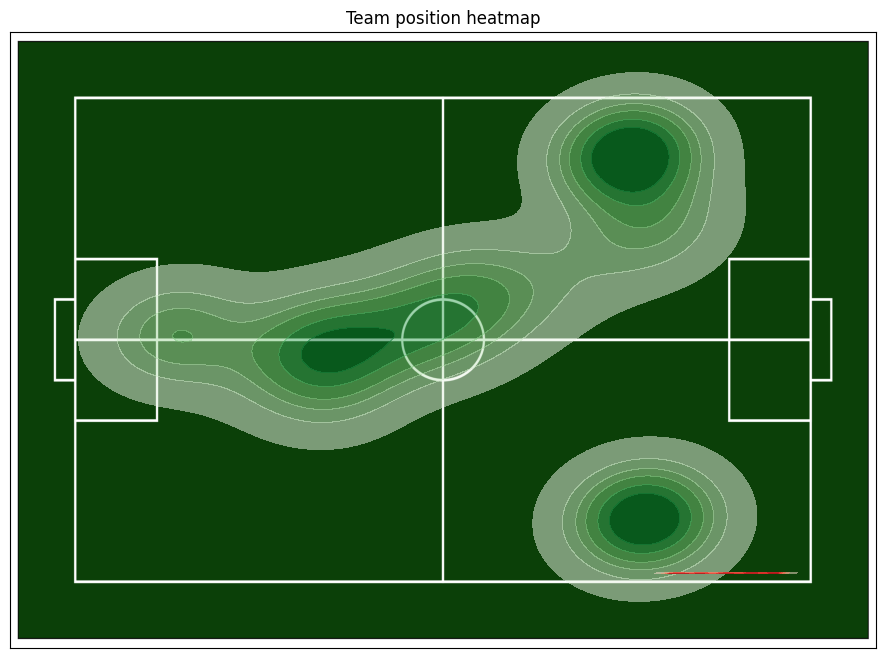

In [6]:
from socceranalyzer import Heatmap

heatmap_plotter = Heatmap(frame, SSL, True)
heatmap_plotter.plot()

# Passes

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

from socceranalyzer.common.enums.ssl import SSL
from socceranalyzer.utils.logger import Logger
from socceranalyzer import Mediator
from socceranalyzer import Point
from socceranalyzer.common.operations.measures import distance_sqrd

class Passes:
    def __init__(self, dataframe, category = SSL, debug = True):
        self.__dataframe = dataframe
        self.__filtered_dataframe = pd.DataFrame
        self.__category = category
        """
        0 -> start point x
        1 -> start point y
        2 -> end point x
        3 -> end point y
        """
        self.__left_successful_passes = []
        self.__left_unsuccessful_passes = []

        self.__right_successful_passes = []
        self.__right_unsuccessful_passes = []
        
        # Left players stand for RoboCIn team in SSL category
        self.__players_left = Mediator.players_left_position(self.__category)
        self.__players_right = Mediator.players_right_position(self.__category)
        self.__ball_range = 115 ** 2

        try:
            self.__calculate()
        except Exception as err:
            Logger.error(err.args[0])
            if debug:
                raise
        else: 
            Logger.success("Passes has results.")

    def __calculate(self):
        self.__filtered_dataframe = self.__dataframe[(self.__dataframe[str(self.__category.PLAYMODE)] == str(self.__category.RUNNING_GAME))]
        self.__filtered_dataframe['kick_x'] = self.__filtered_dataframe.apply(lambda row: self.__find_pass(row, value='ball_acceleration_x'), axis=1)
        self.__filtered_dataframe['kick_y'] = self.__filtered_dataframe.apply(lambda row: self.__find_pass(row, value='ball_acceleration_y'), axis=1)
        
        kicks = self.__filtered_dataframe[(self.__filtered_dataframe['kick_x'] == True) | (self.__filtered_dataframe['kick_y'] == True)]

        previous_index = -199

        for index, row in kicks.iterrows():
            if (index - previous_index <= 50):
                continue
            
            previous_index = index

            passer = self.__ball_holder(self.__dataframe.loc[index])
            if (passer == 'D'):
                continue

            start_x, start_y = self.__dataframe.loc[index][str(self.__category.BALL_X)], self.__dataframe.loc[index][str(self.__category.BALL_Y)]

            ind = index

            while True:
                ind += 1

                if (ind >= len(self.__dataframe)):
                    break
                
                ball_holder = self.__ball_holder(self.__dataframe.loc[ind])

                end_x, end_y = self.__dataframe.loc[ind][str(self.__category.BALL_X)], self.__dataframe.loc[ind][str(self.__category.BALL_Y)]
                
                if (ball_holder == 'D'):
                    continue
                # Game state changed, so it probably went out of bounds, or
                # A member of enemy team got the ball, or
                # The ball ended up in dispute, so the pass wasn't very successful
                if (self.__dataframe.loc[ind][str(self.__category.PLAYMODE)] != str(self.__category.RUNNING_GAME) or
                        ball_holder[1] != passer[1]):
                    
                    if (passer[1] == 'L'):
                        self.__left_unsuccessful_passes.append([start_x, start_y, end_x, end_y])
                    else:
                        self.__right_unsuccessful_passes.append([start_x, start_y, end_x, end_y])

                    break
                
                # A member of the passer's team got the ball
                elif (ball_holder[0] != passer[0] and ball_holder[1] == passer[1]):
                    if (passer[1] == 'L'):
                        self.__left_successful_passes.append([start_x, start_y, end_x, end_y])
                    else:
                        self.__right_successful_passes.append([start_x, start_y, end_x, end_y])
                    
                    break

                else:
                    continue

    def __find_pass(self, df_row, value):
        # Find the index of the current row in the dataframe
        row_index = df_row.name
        
        # Get the last 5 values of acceleration before the current row
        prev_vals = abs(self.__filtered_dataframe.loc[max(row_index-5, int(self.__filtered_dataframe.iloc[0].name)):row_index][value])
        
        # Get the next 5 values of acceleration after the current row
        next_vals = abs(self.__filtered_dataframe.loc[row_index+1:min(row_index+6, self.__filtered_dataframe.iloc[len(self.__filtered_dataframe) - 1].name)][value])
        
        # Calculate the mean of the previous and next values
        prev_mean = prev_vals.mean()
        next_mean = next_vals.mean()
 
        # Calculate the difference between the means
        mean_diff = abs(next_mean - prev_mean)
        
        # Check if the mean difference is greater than or equal to 1000
        if mean_diff >= 1000:
            return True
        else:
            return False 
     
    def __ball_holder(self, df_row):
        """
            Receives a dataframe's row as argument and calculates the closest player to the ball to compute
            who has its possession. If two enemy players are within ball range, none receive its holder
            status
        """
        left_distance = float('inf')
        right_distance = float('inf')

        left_holder_id = -1
        right_holder_id = -1

        ball_x = df_row[str(self.__category.BALL_X)]
        ball_y = df_row[str(self.__category.BALL_Y)]
        ball_position = Point(ball_x, ball_y)

        for i in range(len(self.__players_left.items)):
            player_x = df_row[self.__players_left.items[i].x]
            player_y = df_row[self.__players_left.items[i].y]

            player_position = Point(player_x, player_y)

            player_distance = distance_sqrd(player_position, ball_position)

            if (player_distance < left_distance):
                left_distance = player_distance
                left_holder_id = i

        for i in range(len(self.__players_right.items)):
            player_x = df_row[self.__players_right.items[i].x]
            player_y = df_row[self.__players_right.items[i].y]

            player_position = Point(player_x, player_y)

            player_distance = distance_sqrd(player_position, ball_position)

            if (player_distance < right_distance):
                right_distance = player_distance
                right_holder_id = i

        if ((left_distance <= self.__ball_range and right_distance <= self.__ball_range) or (left_distance > self.__ball_range and right_distance > self.__ball_range)):
            return 'D' # ball in dispute
        elif (left_distance <= self.__ball_range):
            return (left_holder_id, 'L')
        elif (right_distance <= self.__ball_range):
            return (right_holder_id, 'R')
        
    def plot(self, team):
        fig, ax = plt.subplots(figsize=(13.5, 8))

        soccer_pitch = plt.imread('ssl-pitch-f.png')
        ax.imshow(soccer_pitch, extent=[-5200, 5200, -3700, 3700])
        ax.set_xlim(-5200, 5200)
        ax.set_ylim(-3700, 3700)
        ax.set_xticks([])
        ax.set_yticks([])
        
        successful_passes = []
        unsuccessful_passes = []
        side = ""

        if team == 'left':
            successful_passes = self.__left_successful_passes
            unsuccessful_passes = self.__left_unsuccessful_passes

            side = 'ally'
        else:
            successful_passes = self.__right_successful_passes
            unsuccessful_passes = self.__right_unsuccessful_passes

            side = 'enemy'
        
        for pass_ in successful_passes:
            x_vals = [pass_[0], pass_[2]]
            y_vals = [pass_[1], pass_[3]]
            ax.plot(x_vals, y_vals, color='green')
            ax.scatter(x_vals[0], y_vals[0], color='green')
            
        for pass_ in unsuccessful_passes:
            x_vals = [pass_[0], pass_[2]]
            y_vals = [pass_[1], pass_[3]]
            ax.plot(x_vals, y_vals, color='red')
            ax.scatter(x_vals[0], y_vals[0], color='red')

        ax.set_title(f'Successful and unsuccessful passes by {side} team')
        plt.show()


1312
L
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1427
L
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
[ OK ]: Passes has results.
[]


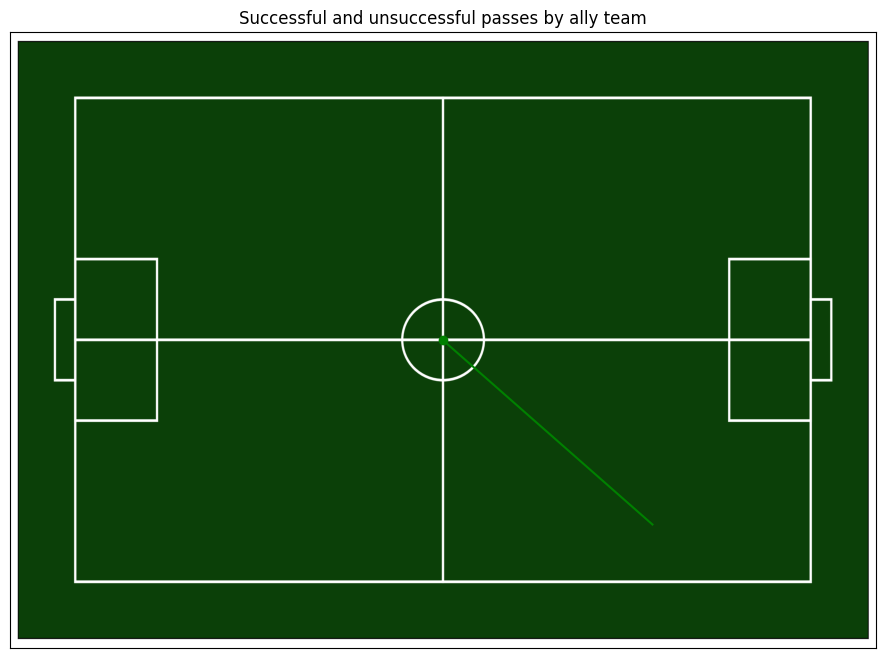

[]


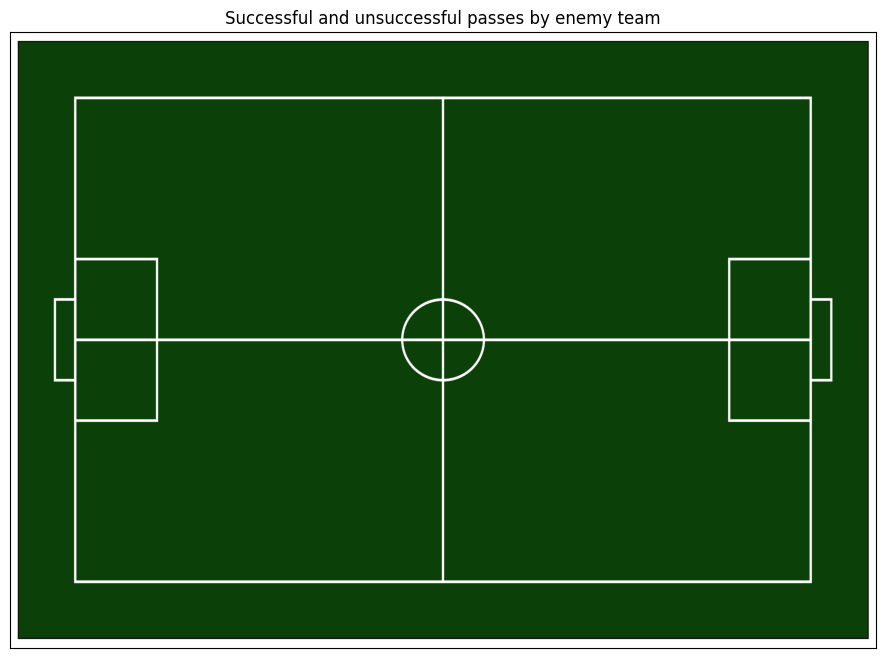

In [13]:
passes_analytics = Passes(frame)
passes_analytics.plot('left')
passes_analytics.plot('right')

Code to create ssl pitch in matplotlib

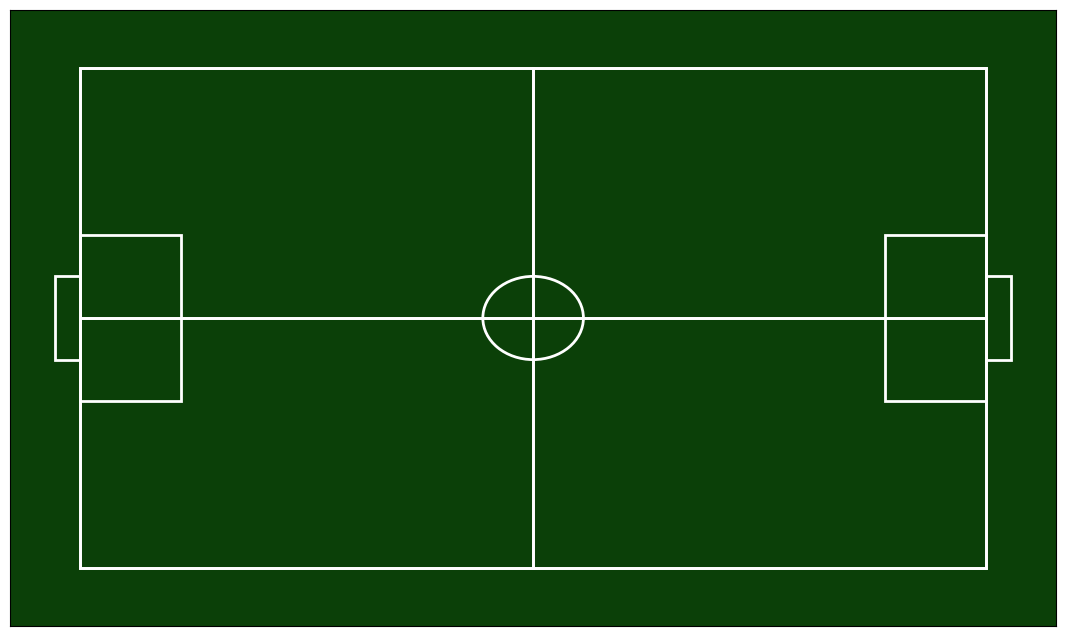

In [16]:
from matplotlib.patches import Rectangle, Circle

# create figure and axis
fig, ax = plt.subplots(figsize=(13.5,8))

# plot field lines
ax.add_patch(Circle((0, 0), 500, facecolor='none', edgecolor='white', linewidth=2))
ax.add_patch(Rectangle((-4500, -3000), 9000, 6000, facecolor='none', edgecolor='white', linewidth=2))


ax.add_patch(Rectangle((-4500, -3000), 4500, 3000, facecolor='none', edgecolor='white', linewidth=2))
ax.add_patch(Rectangle((-4500, 0), 4500, 3000, facecolor='none', edgecolor='white', linewidth=2))
ax.add_patch(Rectangle((0, 0), 4500, 3000, facecolor='none', edgecolor='white', linewidth=2))
ax.add_patch(Rectangle((0, -3000), 4500, 3000, facecolor='none', edgecolor='white', linewidth=2))

ax.add_patch(Rectangle((-4500, -1000), 1000, 2000, facecolor='none', edgecolor='white', linewidth=2))
ax.add_patch(Rectangle((3500, -1000), 1000, 2000, facecolor='none', edgecolor='white', linewidth=2))

ax.add_patch(Rectangle((-4750, -500), 250, 1000, facecolor='none', edgecolor='white', linewidth=2))
ax.add_patch(Rectangle((4500, -500), 250, 1000, facecolor='none', edgecolor='white', linewidth=2))

# set plot limits and remove ticks
ax.set_xlim(-5200, 5200)
ax.set_ylim(-3700, 3700)
ax.set_xticks([])
ax.set_yticks([])

ax.set_facecolor('#0b4008')

# save figure as an image
plt.savefig('soccer_pitch.png', dpi=300, bbox_inches='tight')